# Project Capstone: Fraud Detection on Auto Insurance Claims
**Notebook 3: Feature Engineering, Modelling, Feature Selection, Hyperparameter Tuning and Final Model**

## TABLE OF CONTENTS

**1. Problem Statement, SQL ETL and Exploratory Data Analysis on Dataset** <br>
**2. Preprocessing** <br>
**3. Feature Engineering and Modelling (This Notebook)** <br>
- [Feature Engineering](#Feature-Engineering) <br>
- [Modelling](#Modelling) <br>
- [Feature Selection with Analysis of Variance (ANOVA)](#Feature-Selection-with-Analysis-of-Variance-(ANOVA)) <br>
- [Hyperparameter Tuning with SMOTE](#Hyperparameter-Tuning-with-SMOTE) <br>
- [Final Model](#Final-Model) <br>

**4. Fraud Claim Analysis, Conclusion & Recommendations** <br>

# Feature Engineering

### Import Libraries

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re as re
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay , classification_report, plot_roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

### Import Data

In [2]:
# Read data from csv file.
auto_insurance_dataframe_cleaned = pd.read_csv("./datasets/auto_insurance_dataframe_cleaned.csv")

# Increase display range for easier viewing and EDA.
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
### Visualize Data

In [4]:
# Print number of rows and columns in dataframe.
print(f"Shape:", auto_insurance_dataframe_cleaned.shape)

Shape: (1000, 1147)


In [5]:
# Display first 3 rows of dataframe.
auto_insurance_dataframe_cleaned.head(3)

,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,policy_max_claim_per_occurence,age_when_become_customer,policy_bind_year,policy_bind_month,policy_bind_day,incident_year,incident_month,incident_day,policy_state_IN,policy_state_OH,insured_sex_MALE,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,incident_location_1028 Sky Lane,incident_location_1030 Pine Lane,incident_location_1087 Flute Drive,incident_location_1091 1st Drive,incident_location_1102 Apache Hwy,incident_location_1110 4th Drive,incident_location_1123 5th Lane,incident_location_1126 Texas Hwy,incident_location_1128 Maple Lane,incident_location_1133 Apache St,incident_location_1135 Solo Lane,incident_location_1173 Andromedia Ave,incident_location_1186 Rock St,incident_location_1213 4th Lane,incident_location_1215 Pine Hwy,incident_location_1218 Sky Hwy,incident_location_1220 MLK Ave,incident_location_1229 5th Ave,incident_location_1240 Tree Lane,incident_location_1248 MLK Ridge,incident_location_1267 Francis Hwy,incident_location_1269 Flute Drive,incident_location_1273 Rock Lane,incident_location_1275 4th Ridge,incident_location_1298 Maple Hwy,incident_location_1306 Andromedia St,incident_location_1316 Britain Ridge,incident_location_1320 Flute Lane,incident_location_1325 1st Lane,incident_location_1328 Texas Lane,incident_location_1331 Britain Hwy,incident_location_1331 Elm Ridge,incident_location_1346 5th Lane,incident_location_1353 Washington St,incident_location_1358 Maple St,incident_location_1364 Best St,incident_location_1365 Francis Ave,incident_location_1371 Texas Lane,incident_location_1376 Pine St,incident_location_1381 Francis Ave,incident_location_1386 Britain St,incident_location_1388 Embaracadero Hwy,incident_location_1416 Cherokee Ridge,incident_location_1422 Flute Ave,incident_location_1437 3rd Lane,incident_location_1454 5th Ridge,incident_location_1469 Lincoln Drive,incident_location_1472 4th Drive,incident_location_1491 Francis Ridge,incident_location_1507 S

In [6]:
# Summary of dataframe.
print("********************************************************")
print("       Summary of Auto Insurance Dataframe              ")
print("********************************************************")
auto_insurance_dataframe_cleaned.info()

********************************************************
       Summary of Auto Insurance Dataframe              
********************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1147 entries, policy_number to auto_model_X6
dtypes: float64(2), int64(1145)
memory usage: 8.8 MB


### Select Features

All columns from auto_insurance_dataframe_cleaned will be selected as features except `fraud_reported`.

In [7]:
# Drop "fraud_reported" and select the remaining columns as features. 
selected_features = auto_insurance_dataframe_cleaned.drop(['fraud_reported'], axis=1)

# Modelling

Fraud prediction is supervised classification problem, whose dependent variable (target variable or output) is categorical variable ([source](https://elitedatascience.com/machine-learning-algorithms)). Hence, these algorithms will be trained based on prelabelled data and make prediction:
- [(1) (Regularized) Logistic Regression](#1.-(Regularized)-Logistic-Regression) <br>
- [(2) Classification Tree (Ensembles)](#2.-Classification-Tree-(Ensembles)) <br>
- [(3) Support Vector Machines](#3.-Support-Vector-Machines) <br>
- [(4) Naive Bayes](#4.-Naive-Bayes) <br>

In this section, the following process will be carried out:
- Set up Data for Modelling
- Split Data into Training and Testing Sets
- Calculate Baseline and other Benchmark Models
- Fit model to training data
- Ran models on our data without using any feature selection and over- or under-sampling techniques to benchmark performance
- Used the Feature Selection with <b>Analysis of Variance (ANOVA)</b> to address overfitting
- Used the <b>Synthetic Minority Oversampling Technique (SMOTE)</b> to address the class imbalance within our target variable
- Carried out feature selection and hyper-parameter tuning on our most promising models 
- Identified our top performing model based on ROC-AUC score

#### Set up Data for Modelling

In [8]:
# `X` will be the `selected_features` columns.
# `y` will be the `fraud_reported` column.
X = selected_features
y = auto_insurance_dataframe_cleaned['fraud_reported']

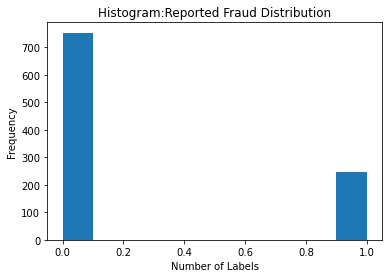

In [9]:
# Draw histogram to show distribution. 
plt.hist(y)
plt.ylabel("Frequency")
plt.xlabel("Number of Labels")
plt.title("Histogram:Reported Fraud Distribution");

**Observations**:
- There are 2 labels: 0 represents no fraud reported and 1 represents fraud reported. 
- There is a significant difference between the number of no fraud reported labels and fraud reported labels. 

#### Split Data into Training and Testing Sets

Because of imbalance distribution, model that is trained on a vastly different labels distribution than the test set will perform inferiorly at validation. To resolve this problem, distribution of labels in train and test datasets will be locked via stratification.

In [10]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,   # 30% of data is retained for testing.
                                                    stratify=y,       # to keep the same balance of y in the test and train data.0
                                                    random_state=42)

In [11]:
# Display shape of X_train and X_test.
# Print X_train shape.
print(f"X_train shape:", X_train.shape)
# Print X_test shape.
print(f"X_test shape:", X_test.shape)

X_train shape: (700, 1146)
X_test shape: (300, 1146)


In [12]:
# Display first 5 rows of X_train.
X_train.head()

,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,policy_max_claim_per_occurence,age_when_become_customer,policy_bind_year,policy_bind_month,policy_bind_day,incident_year,incident_month,incident_day,policy_state_IN,policy_state_OH,insured_sex_MALE,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,incident_location_1028 Sky Lane,incident_location_1030 Pine Lane,incident_location_1087 Flute Drive,incident_location_1091 1st Drive,incident_location_1102 Apache Hwy,incident_location_1110 4th Drive,incident_location_1123 5th Lane,incident_location_1126 Texas Hwy,incident_location_1128 Maple Lane,incident_location_1133 Apache St,incident_location_1135 Solo Lane,incident_location_1173 Andromedia Ave,incident_location_1186 Rock St,incident_location_1213 4th Lane,incident_location_1215 Pine Hwy,incident_location_1218 Sky Hwy,incident_location_1220 MLK Ave,incident_location_1229 5th Ave,incident_location_1240 Tree Lane,incident_location_1248 MLK Ridge,incident_location_1267 Francis Hwy,incident_location_1269 Flute Drive,incident_location_1273 Rock Lane,incident_location_1275 4th Ridge,incident_location_1298 Maple Hwy,incident_location_1306 Andromedia St,incident_location_1316 Britain Ridge,incident_location_1320 Flute Lane,incident_location_1325 1st Lane,incident_location_1328 Texas Lane,incident_location_1331 Britain Hwy,incident_location_1331 Elm Ridge,incident_location_1346 5th Lane,incident_location_1353 Washington St,incident_location_1358 Maple St,incident_location_1364 Best St,incident_location_1365 Francis Ave,incident_location_1371 Texas Lane,incident_location_1376 Pine St,incident_location_1381 Francis Ave,incident_location_1386 Britain St,incident_location_1388 Embaracadero Hwy,incident_location_1416 Cherokee Ridge,incident_location_1422 Flute Ave,incident_location_1437 3rd Lane,incident_location_1454 5th Ridge,incident_location_1469 Lincoln Drive,incident_location_1472 4th Drive,incident_location_1491 Francis Ridge,incident_location_1507 Solo Ave,inciden

# Baseline Model

Baseline model serves as a baseline for comparison against new models.

In [13]:
# Baseline model accuracy
y_test.value_counts(normalize = True)

0    0.753333
1    0.246667
Name: fraud_reported, dtype: float64

In [14]:
y_test.value_counts()

0    226
1     74
Name: fraud_reported, dtype: int64

With all actual fraudulent claims assumed to be identified correctly, scores will be as below:

In [15]:
# Calculate the specificity rate
baseline_specificity = 0/(226)

# Calculate sensitivity/recall (percentage of actual positives was identified correctly)
baseline_sensitivity = 74/(74)

# Calculate precision (percentage of positive identifications that is actually correct)
baseline_precision = 74/(300)

# Calculate f1 score (f1 score is the harmonic mean of the precision and recall)
baseline_f1 = 2 * baseline_sensitivity * baseline_precision / (baseline_sensitivity + baseline_precision)

baseline_df = pd.DataFrame()
baseline_df['y']=y_test
baseline_df['pred']=1
auc_score = roc_auc_score(baseline_df['y'], baseline_df['pred'])

print(f'Specificity: ''{:.0%}'.format(baseline_specificity, 2))
print(f'Sensitivity: ''{:.0%}'.format(baseline_sensitivity, 2))
print(f'Precision: ''{:.0%}'.format(baseline_precision, 2))
print(f'F1 Score: ''{:.0%}'.format(baseline_f1, 2))
print(f'ROC AUC Score: ''{:.0%}'.format(auc_score, 2))

Specificity: 0%
Sensitivity: 100%
Precision: 25%
F1 Score: 40%
ROC AUC Score: 50%


#### Baseline Model Score

The dataset is imbalanced and is strongly biased towards non-fraudulent insurance claims. This means that simply classifing every data point as non-fraudulent insurance claims would <b>score our model an accuracy of 75%</b>. Hence, accuracy is not a good measure of success as high accuracy is not equivalent to high accuracy in predicting fraudulent insurance claims. 

In this situation, different metrics are required such as F1 score and ROC AUC.
- F1 score: harmonic mean of the precision and recall. Highest possible value of an F-score is 1.0, indicating perfect precision and recall, and lowest possible value is 0, if both precision and recall are zero ([source](https://en.wikipedia.org/wiki/F-score)).
- ROC AUC (Reciever Operating Characteristic Area under Curve): provides visual comparison between true positive and false positive rates at a range of different classification thresholds. To elaborate, AUC measures how true positive rate (recall) and false positive rate trade off. This reveals how good a model is at distinguishing between fraudulent insurance claims and non-fraudulent insurance claims ([source](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)). 

As the goal of this project is to predict as many fraudulent insurance claims as possible, F1 score and ROC AUC score of 40\% and 50\% are used as baselines. </b>.

# Benchmark Models

Models are run with no feature selection, no class adjustments and no hyper-parameter tuning.

In [16]:
# Instiantiate models
models = {'lr': LogisticRegression(random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'gnb': GaussianNB()
        }

In [17]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=10, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    


    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = '{:.0%}'.format(roc_auc_score(y_train, y_train_pred_prob))
    results['test_auc'] = '{:.0%}'.format(roc_auc_score(y_test, y_test_pred_prob))
    
    results['training_score'] = '{:.0%}'.format(pipe.score(X_train,y_train))
    results['testing_score'] = '{:.0%}'.format(pipe.score(X_test,y_test))
    
    
    if grid_search:
        gs_list.append(results)
        # Derive best parameters.
        print('***************************** Best Parameters **********************************')
        display(pipe.best_params_)
        
    # else:
        # init_list.append(results)
    
    print('********************************** Model Metrics **********************************')
    display(results)
    
    print('******************************* Confusion Matrix **********************************')
    
    # Create a confusion matrix.
    predictions = pipe.predict(X_test)
    cm_def = np.array([['True Negative', 'False Positive'],
                      ['False Negative', 'True Positive']])
    cm_def = pd.DataFrame(cm_def,columns = ['Predicted Negative', 'Predicted Positive'], index = ['Actual Negative','Actual Positive'])
    display(cm_def)
    
    # ravel() to convert to 1-D and Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')
    
    # Display confusion matrix in dataframe.
    cm =  confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm, columns = ['Predicted Negative', 'Predicted Positive'], index = ['Actual Negative','Actual Positive'])
    display(cm_df)
     
    # Calculate accuracy rate (percentage of labels model correctly predict)
    accuracy = ( tp + tn ) / ( tp + fp + tn + fn )
    results['accuracy'] = '{:.0%}'.format(accuracy)
    
    # Calculate misclassification rate (percentage of labels model incorrectly predict)
    misclassification = ( fp + fn ) / ( tp + fp + tn + fn )
    results['misclassification'] = '{:.0%}'.format(misclassification)
    
    # Calculate the specificity rate
    specificity = tn / ( tn + fp )
    results['specificity'] = '{:.0%}'.format(specificity)

    # Calculate sensitivity/recall (percentage of actual positives was identified correctly)
    sensitivity = tp / ( tp + fn )
    results['sensitivity'] = '{:.0%}'.format(sensitivity)
    
    # Calculate precision (percentage of positive identifications that is actually correct)
    precision = tp / ( tp + fp)
    results['precision'] = '{:.0%}'.format(precision)
    
    # Calculate f1 score (F1 score is the harmonic mean of the precision and recall)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    results['f1_score'] = '{:.0%}'.format(f1_score)
    
    print(f'Accuracy Rate: ''{:.0%}'.format(accuracy, 2))
    print(f'Misclassifcation Rate: ''{:.0%}'.format(misclassification, 2))
    print(f'Specificity: ''{:.0%}'.format(specificity, 2))
    print(f'Sensitivity: ''{:.0%}'.format(sensitivity, 2))
    print(f'Precision: ''{:.0%}'.format(precision, 2))
    print(f'F1 Score: ''{:.0%}'.format(f1_score, 2))
    
    print('************************************* ROC AUC *************************************')
    
    # Draw AUC ROC curve.    
    import warnings
    warnings.filterwarnings("ignore")
    plot_roc_curve(pipe, X_test, y_test)
    plt.title("ROC Curve")
    plt.legend();
    
    init_list.append(results)
    
    return pipe

### Logistic Regression

********************************** Model Metrics **********************************


{'model': 'lr',
 'train_auc': '100%',
 'test_auc': '78%',
 'training_score': '100%',
 'testing_score': '75%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 219, False Positives: 7, False Negatives: 67, True Positives: 7


,Predicted Negative,Predicted Positive
Actual Negative,219,7
Actual Positive,67,7


Accuracy Rate: 75%
Misclassifcation Rate: 25%
Specificity: 97%
Sensitivity: 9%
Precision: 50%
F1 Score: 16%
************************************* ROC AUC *************************************


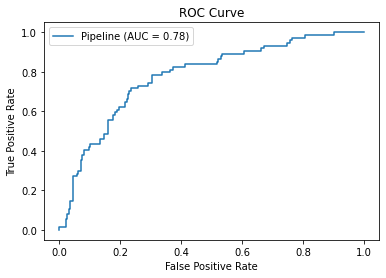

In [18]:
# Run logistic Regression.
lr = run_model('lr')

### Random Forest

********************************** Model Metrics **********************************


{'model': 'rf',
 'train_auc': '100%',
 'test_auc': '78%',
 'training_score': '100%',
 'testing_score': '75%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 225, False Positives: 1, False Negatives: 73, True Positives: 1


,Predicted Negative,Predicted Positive
Actual Negative,225,1
Actual Positive,73,1


Accuracy Rate: 75%
Misclassifcation Rate: 25%
Specificity: 100%
Sensitivity: 1%
Precision: 50%
F1 Score: 3%
************************************* ROC AUC *************************************


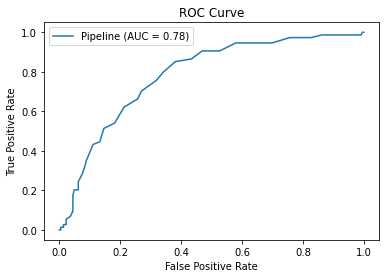

In [19]:
# Run Random Forest Classifier.
rf = run_model('rf')

### Decision Tree

********************************** Model Metrics **********************************


{'model': 'dt',
 'train_auc': '100%',
 'test_auc': '75%',
 'training_score': '100%',
 'testing_score': '82%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 200, False Positives: 26, False Negatives: 28, True Positives: 46


,Predicted Negative,Predicted Positive
Actual Negative,200,26
Actual Positive,28,46


Accuracy Rate: 82%
Misclassifcation Rate: 18%
Specificity: 88%
Sensitivity: 62%
Precision: 64%
F1 Score: 63%
************************************* ROC AUC *************************************


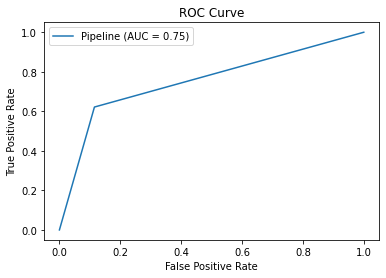

In [20]:
# Run Decision Tree Classifier.
dt = run_model('dt')

### Extra Tree

********************************** Model Metrics **********************************


{'model': 'et',
 'train_auc': '100%',
 'test_auc': '81%',
 'training_score': '100%',
 'testing_score': '74%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 221, False Positives: 5, False Negatives: 73, True Positives: 1


,Predicted Negative,Predicted Positive
Actual Negative,221,5
Actual Positive,73,1


Accuracy Rate: 74%
Misclassifcation Rate: 26%
Specificity: 98%
Sensitivity: 1%
Precision: 17%
F1 Score: 2%
************************************* ROC AUC *************************************


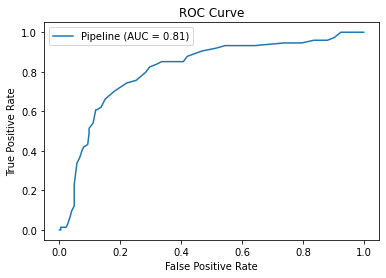

In [21]:
# Run Extra Trees Classifier.
et = run_model('et')

### Adaptive Boosting

********************************** Model Metrics **********************************


{'model': 'ada',
 'train_auc': '97%',
 'test_auc': '80%',
 'training_score': '90%',
 'testing_score': '77%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 206, False Positives: 20, False Negatives: 48, True Positives: 26


,Predicted Negative,Predicted Positive
Actual Negative,206,20
Actual Positive,48,26


Accuracy Rate: 77%
Misclassifcation Rate: 23%
Specificity: 91%
Sensitivity: 35%
Precision: 57%
F1 Score: 43%
************************************* ROC AUC *************************************


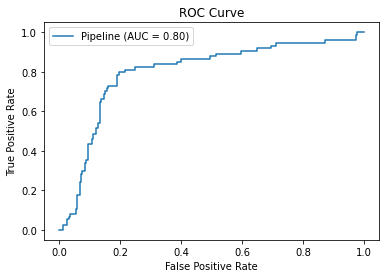

In [22]:
# Run Adaptive Boosting.
ada = run_model('ada')

### Gradient Boosting

********************************** Model Metrics **********************************


{'model': 'gb',
 'train_auc': '100%',
 'test_auc': '83%',
 'training_score': '100%',
 'testing_score': '80%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 207, False Positives: 19, False Negatives: 40, True Positives: 34


,Predicted Negative,Predicted Positive
Actual Negative,207,19
Actual Positive,40,34


Accuracy Rate: 80%
Misclassifcation Rate: 20%
Specificity: 92%
Sensitivity: 46%
Precision: 64%
F1 Score: 54%
************************************* ROC AUC *************************************


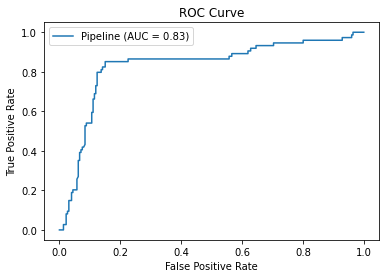

In [23]:
# Run Gradient Tree Boosting.
gb = run_model('gb')

### Support Vector Classifier

********************************** Model Metrics **********************************


{'model': 'svc',
 'train_auc': '100%',
 'test_auc': '75%',
 'training_score': '100%',
 'testing_score': '75%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 226, False Positives: 0, False Negatives: 74, True Positives: 0


,Predicted Negative,Predicted Positive
Actual Negative,226,0
Actual Positive,74,0


Accuracy Rate: 75%
Misclassifcation Rate: 25%
Specificity: 100%
Sensitivity: 0%
Precision: nan%
F1 Score: nan%
************************************* ROC AUC *************************************


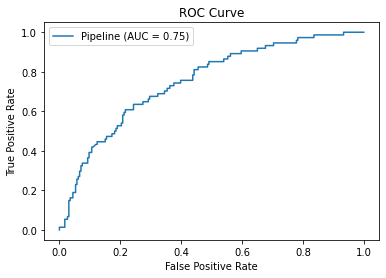

In [24]:
# Run Support Vector Classifier.
svc = run_model('svc')

 ### Gaussian Naive Bayes

********************************** Model Metrics **********************************


{'model': 'gnb',
 'train_auc': '100%',
 'test_auc': '49%',
 'training_score': '100%',
 'testing_score': '26%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 6, False Positives: 220, False Negatives: 3, True Positives: 71


,Predicted Negative,Predicted Positive
Actual Negative,6,220
Actual Positive,3,71


Accuracy Rate: 26%
Misclassifcation Rate: 74%
Specificity: 3%
Sensitivity: 96%
Precision: 24%
F1 Score: 39%
************************************* ROC AUC *************************************


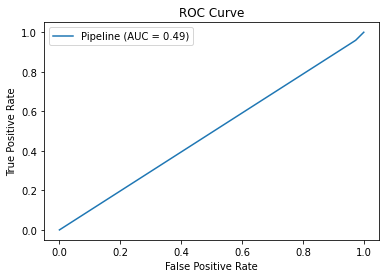

In [25]:
# Run Gaussian Naive Bayes.
gnb = run_model('gnb')

In [26]:
# Results of initial modelling.
pd.DataFrame(init_list).sort_values(by='f1_score', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,training_score,testing_score,accuracy,misclassification,specificity,sensitivity,precision,f1_score
0,svc,100%,75%,100%,75%,75%,25%,100%,0%,nan%,nan%
1,dt,100%,75%,100%,82%,82%,18%,88%,62%,64%,63%
2,gb,100%,83%,100%,80%,80%,20%,92%,46%,64%,54%
3,ada,97%,80%,90%,77%,77%,23%,91%,35%,57%,43%
4,gnb,100%,49%,100%,26%,26%,74%,3%,96%,24%,39%
5,rf,100%,78%,100%,75%,75%,25%,100%,1%,50%,3%
6,et,100%,81%,100%,74%,74%,26%,98%,1%,17%,2%
7,lr,100%,78%,100%,75%,75%,25%,97%,9%,50%,16%


**Observations**:
- Majority of the models have overfitting issues with 100% training score except for Adaptive Boosting.
- All models do not generalize well with new data as there is a huge gap between training score and testing score. 
- Support Vector Classification fails to identify any true positives, which are the actual fraudulent insurance claims.
- When compare to baseline model, Gaussian Naive Bayes, Logistic Regression, Random Forest Classifier, Extra Trees Classifier have poorer F1 score. This means the models are poorer in identifying true positives, which are the actual fraudulent insurance claims.
- Decision Tree Classfier has the best F1 score. However, it has overfitting issue (same applies to all other models) and so the results are not credible.
- Gradient Boosting Classfier has the second best F1 score but it scores poorly in terms of sensitivity, suggesting that the model is not good at identifying true positives (i.e. insurance claim that is fraudulent).

### AUC-ROC Evaluation

In [27]:
init_dict = {
    lr: 'LogisticRegression',
    rf: 'RandomForest',
    dt: 'DecisionTreeClassifier',
    et: 'ExtraTrees',
    ada: 'AdaBoostClassifier',
    gb: 'GradientBoostingClassifier',
    svc: 'SupportVectorMachineCl',
    gnb: 'GaussianNB'
}

In [28]:
# Function to plot ROC AUC.
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

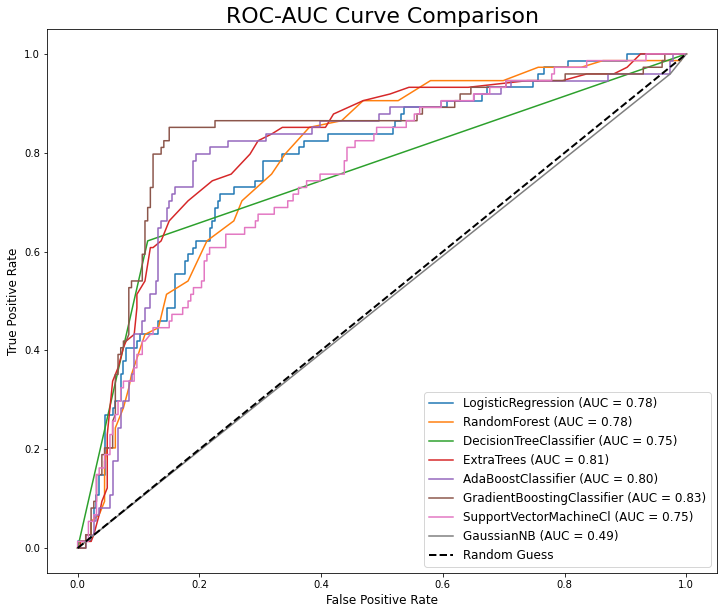

In [29]:
# Plot ROC AUC.
roc_curve_plotter(init_dict)

**Observation**:
- Gradient Boosting Classifier has the highest AUC.
- Gaussian Naive Bayes has the lowest AUC, which is also lower than random guess. 

## Feature Selection with Analysis of Variance (ANOVA)

Analysis of Variance (ANOVA) is used to identify and select features that are important to modelling via P value.  The smaller the P value the more significant the difference in the features ([source](https://ml2021.medium.com/chi-square-and-anova-feature-selection-for-ml-5e1063ab0991)). 

In [30]:
# Use the f_classif method.
univariate = f_classif(X_train, y_train)
univariate

(array([2.2422923 , 0.35008761, 0.02804142, ..., 1.08956578, 0.20610139,
        2.58584546]),
 array([0.13473384, 0.55425512, 0.86705998, ..., 0.29692881, 0.64998154,
        0.10827502]))

In [31]:
# 2nd values are the PValue, which are captured as below.
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
# Features are ranked in descending order based on P value. The smaller the P value the more significant the difference in the features.
univariate.sort_values(ascending = False)

capital-gains                                9.928534e-01
insured_relationship_not-in-family           9.842355e-01
auto_model_Fusion                            9.786551e-01
insured_hobbies_board-games                  9.715150e-01
insured_hobbies_paintball                    9.699196e-01
insured_occupation_tech-support              9.588592e-01
auto_make_Honda                              9.550202e-01
insured_education_level_College              9.498954e-01
auto_make_Suburu                             9.208277e-01
insured_sex_MALE                             9.205846e-01
insured_education_level_Masters              9.104109e-01
auto_model_93                                9.088781e-01
policy_state_IN                              9.073319e-01
auto_make_Toyota                             8.919620e-01
incident_state_PA                            8.768917e-01
policy_annual_premium                        8.670600e-01
auto_model_Camry                             8.595921e-01
auto_model_Imp

In [32]:
# Get the top Selected Features.
# Implement SelectKBest with f_classif.
sel_train = SelectKBest(f_classif, k = 10).fit(X_train, y_train) 
# Get the columns' names.
X_train.columns[sel_train.get_support()]

Index(['total_claim_amount', 'insured_hobbies_chess',
       'insured_hobbies_cross-fit', 'incident_type_Parked Car',
       'incident_type_Vehicle Theft', 'incident_severity_Minor Damage',
       'incident_severity_Total Loss', 'incident_severity_Trivial Damage',
       'authorities_contacted_None', 'property_damage_NO'],
      dtype='object')

In [33]:
# Apply transformation to remove features that are not important.
X_train = sel_train.transform(X_train)
X_test = sel_train.transform(X_test)

## Hyperparameter Tuning with SMOTE

SMOTE is a commonly used oversampling method that attempts to balance class distribution by randomly increasing minority class labels by replicating them. SMOTE creates new minority labels between existing minority labels. SMOTE works by selecting labels that are close in the feature space, drawing a line between the labels in the feature space and drawing a new label at a point along that line. 

As dataset is imbalanced, SMOTE is a good method to balance class distribution. Another option that is considered was <b>class weights</b>, where a heavier weightage is placed on the minority class and vice-versa for the majority class. However, SMOTE is selected as some models like Adaptive Boosting classifier and Gradient Boosting classifier cannot use class weights.

In [34]:
# Transform the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [35]:
# Instiantiate models
models = {'lr': LogisticRegression(random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'gnb': GaussianNB()
        }

### Logistic Regression

In [36]:
lr_params = [{
    # Trying different types of regularization
    'lr__penalty':['l2'],
    
     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[0.1, 0.5, 1.0],
    
    # Trying different solvers
    'lr__solver': ['newton-cg', 'newton-cg','lbfgs', 'sag', 'saga']}]

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s


***************************** Best Parameters **********************************


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished


{'lr__C': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}

********************************** Model Metrics **********************************


{'model': 'lr',
 'train_auc': '92%',
 'test_auc': '85%',
 'training_score': '87%',
 'testing_score': '85%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 192, False Positives: 34, False Negatives: 10, True Positives: 64


,Predicted Negative,Predicted Positive
Actual Negative,192,34
Actual Positive,10,64


Accuracy Rate: 85%
Misclassifcation Rate: 15%
Specificity: 85%
Sensitivity: 86%
Precision: 65%
F1 Score: 74%
************************************* ROC AUC *************************************


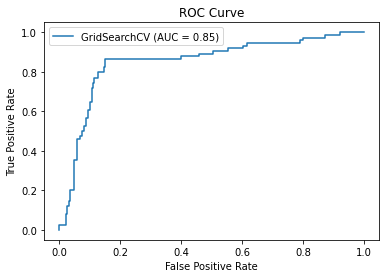

In [37]:
lr_gs = run_model('lr', mod_params=lr_params, grid_search=True)

### Random Forest

In [38]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.7s


***************************** Best Parameters **********************************


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.6s finished


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 30}

********************************** Model Metrics **********************************


{'model': 'rf',
 'train_auc': '99%',
 'test_auc': '84%',
 'training_score': '94%',
 'testing_score': '84%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 198, False Positives: 28, False Negatives: 20, True Positives: 54


,Predicted Negative,Predicted Positive
Actual Negative,198,28
Actual Positive,20,54


Accuracy Rate: 84%
Misclassifcation Rate: 16%
Specificity: 88%
Sensitivity: 73%
Precision: 66%
F1 Score: 69%
************************************* ROC AUC *************************************


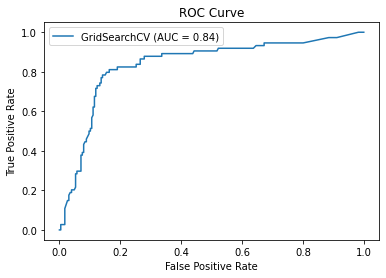

In [39]:
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)

### Decision Tree

In [40]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s


***************************** Best Parameters **********************************


[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    0.5s finished


{'dt__class_weight': 'balanced',
 'dt__max_depth': 30,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 5}

********************************** Model Metrics **********************************


{'model': 'dt',
 'train_auc': '99%',
 'test_auc': '82%',
 'training_score': '94%',
 'testing_score': '82%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 194, False Positives: 32, False Negatives: 23, True Positives: 51


,Predicted Negative,Predicted Positive
Actual Negative,194,32
Actual Positive,23,51


Accuracy Rate: 82%
Misclassifcation Rate: 18%
Specificity: 86%
Sensitivity: 69%
Precision: 61%
F1 Score: 65%
************************************* ROC AUC *************************************


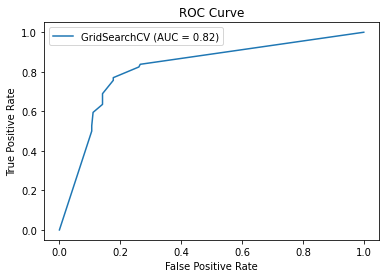

In [41]:
dt_gs =  run_model('dt', mod_params=dt_params, grid_search=True)

### Extra Tree

In [42]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s


***************************** Best Parameters **********************************


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    1.9s finished


{'et__max_depth': 30, 'et__min_samples_leaf': 2, 'et__n_estimators': 25}

********************************** Model Metrics **********************************


{'model': 'et',
 'train_auc': '97%',
 'test_auc': '84%',
 'training_score': '90%',
 'testing_score': '85%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 192, False Positives: 34, False Negatives: 11, True Positives: 63


,Predicted Negative,Predicted Positive
Actual Negative,192,34
Actual Positive,11,63


Accuracy Rate: 85%
Misclassifcation Rate: 15%
Specificity: 85%
Sensitivity: 85%
Precision: 65%
F1 Score: 74%
************************************* ROC AUC *************************************


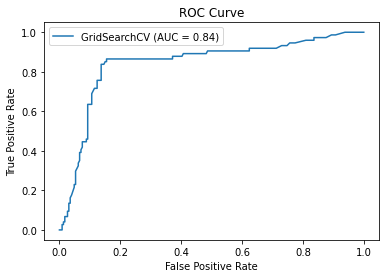

In [43]:
et_gs =  run_model('et', mod_params=et_params, grid_search=True)

### Adaptive Boosting

In [44]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.5s finished


***************************** Best Parameters **********************************


{'ada__learning_rate': 0.9, 'ada__n_estimators': 500}

********************************** Model Metrics **********************************


{'model': 'ada',
 'train_auc': '98%',
 'test_auc': '83%',
 'training_score': '93%',
 'testing_score': '82%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 195, False Positives: 31, False Negatives: 23, True Positives: 51


,Predicted Negative,Predicted Positive
Actual Negative,195,31
Actual Positive,23,51


Accuracy Rate: 82%
Misclassifcation Rate: 18%
Specificity: 86%
Sensitivity: 69%
Precision: 62%
F1 Score: 65%
************************************* ROC AUC *************************************


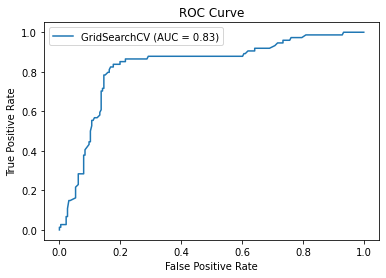

In [45]:
ada_gs = run_model('ada', mod_params=ada_params, grid_search=True)

### Gradient Boosting

In [46]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.7s finished


***************************** Best Parameters **********************************


{'gb__learning_rate': 0.6, 'gb__n_estimators': 1000}

********************************** Model Metrics **********************************


{'model': 'gb',
 'train_auc': '100%',
 'test_auc': '82%',
 'training_score': '99%',
 'testing_score': '79%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 191, False Positives: 35, False Negatives: 28, True Positives: 46


,Predicted Negative,Predicted Positive
Actual Negative,191,35
Actual Positive,28,46


Accuracy Rate: 79%
Misclassifcation Rate: 21%
Specificity: 85%
Sensitivity: 62%
Precision: 57%
F1 Score: 59%
************************************* ROC AUC *************************************


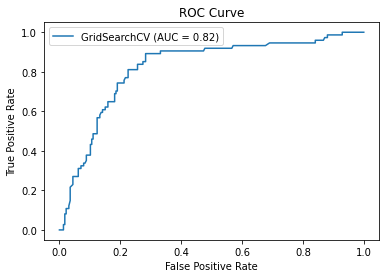

In [47]:
gb_gs = run_model('gb', mod_params=gb_params, grid_search=True)

### Support Vector Classifier

In [48]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished


***************************** Best Parameters **********************************


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

********************************** Model Metrics **********************************


{'model': 'svc',
 'train_auc': '95%',
 'test_auc': '84%',
 'training_score': '90%',
 'testing_score': '85%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 192, False Positives: 34, False Negatives: 12, True Positives: 62


,Predicted Negative,Predicted Positive
Actual Negative,192,34
Actual Positive,12,62


Accuracy Rate: 85%
Misclassifcation Rate: 15%
Specificity: 85%
Sensitivity: 84%
Precision: 65%
F1 Score: 73%
************************************* ROC AUC *************************************


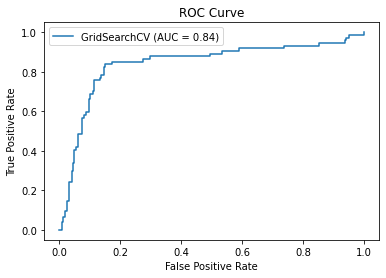

In [49]:
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

### Gaussian Naive Bayes

In [50]:
gnb_params ={'gnb__var_smoothing': [0.000000002, 0.000000003, 0.000000004]}

Fitting 10 folds for each of 3 candidates, totalling 30 fits
***************************** Best Parameters **********************************


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


{'gnb__var_smoothing': 2e-09}

********************************** Model Metrics **********************************


{'model': 'gnb',
 'train_auc': '91%',
 'test_auc': '86%',
 'training_score': '88%',
 'testing_score': '85%'}

******************************* Confusion Matrix **********************************


,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


True Negatives: 192, False Positives: 34, False Negatives: 10, True Positives: 64


,Predicted Negative,Predicted Positive
Actual Negative,192,34
Actual Positive,10,64


Accuracy Rate: 85%
Misclassifcation Rate: 15%
Specificity: 85%
Sensitivity: 86%
Precision: 65%
F1 Score: 74%
************************************* ROC AUC *************************************


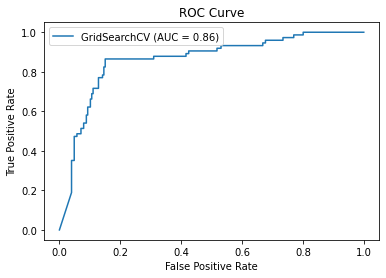

In [51]:
gnb_gs =  run_model('gnb', mod_params=gnb_params, grid_search=True)

In [52]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='f1_score', ascending=False)

,model,train_auc,test_auc,training_score,testing_score,accuracy,misclassification,specificity,sensitivity,precision,f1_score
0,lr,92%,85%,87%,85%,85%,15%,85%,86%,65%,74%
3,et,97%,84%,90%,85%,85%,15%,85%,85%,65%,74%
7,gnb,91%,86%,88%,85%,85%,15%,85%,86%,65%,74%
6,svc,95%,84%,90%,85%,85%,15%,85%,84%,65%,73%
1,rf,99%,84%,94%,84%,84%,16%,88%,73%,66%,69%
2,dt,99%,82%,94%,82%,82%,18%,86%,69%,61%,65%
4,ada,98%,83%,93%,82%,82%,18%,86%,69%,62%,65%
5,gb,100%,82%,99%,79%,79%,21%,85%,62%,57%,59%


**Observations**:
- All models, except Gaussian Naive Bayes, have overfitting issues.
- Logistic Regression, Extra Tree and Gaussian Naive Bayes have the highest f1 score at 74%.
- Gaussian Naive Bayes has highest testing ROC AUC at 86%.

### Final AUC-ROC Evaluation

In [53]:
gs_dict = {
    lr_gs: 'LogisticRegression',
    rf_gs: 'RandomForest',
    dt_gs: 'DecisionTreeClassifier',
    et_gs: 'ExtraTrees',
    ada_gs: 'AdaBoostClassifier',
    gb_gs: 'GradientBoostingClassifier',
    svc_gs: 'SupportVectorMachineCl',
    gnb_gs: 'GaussianNB'
}

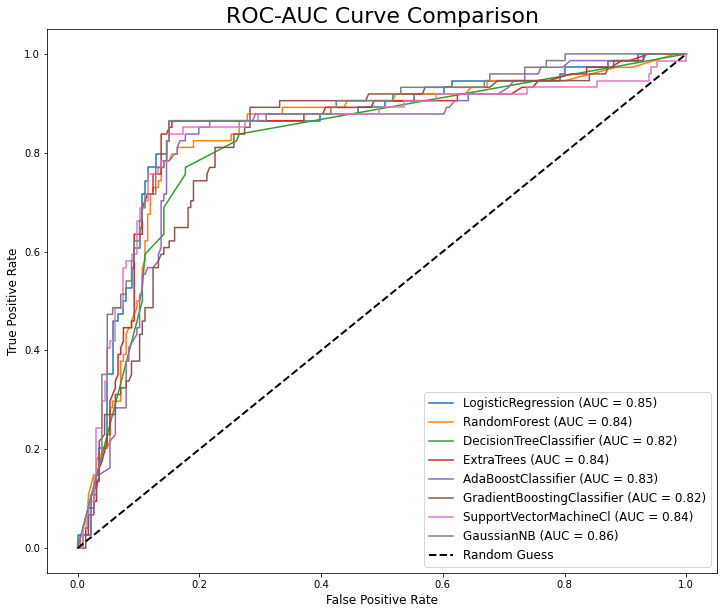

In [54]:
roc_curve_plotter(gs_dict)

**Observations**:
- All models' AUC is at least 82\%. 
- Gaussian Naive Bayes has the highest AUC at 86\%.

In [55]:
# Function to create recall / precision curve.
def plot_pr_curve(model, model_dict):
    # Predict probabilities
    probs = model.predict_proba(X_test)
    # Keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # Predict class values
    yhat = model.predict(X_test)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, yhat)
    # Calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # Calculate average precision score
    ap = average_precision_score(y_test, probs)
    print(f'{model_dict[model]}:', 'f1 score=' + '{:.0%}'.format(f1), 'precision recall auc:' + '{:.0%}'.format(auc_score), 'average precision score:' + '{:.0%}'.format(ap))
    # Plot the ROC curve for the model
    plt.plot(recall, precision, marker='.', label=model_dict[model])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

LogisticRegression: f1 score=74% precision recall auc:61% average precision score:62%
RandomForest: f1 score=69% precision recall auc:57% average precision score:59%
DecisionTreeClassifier: f1 score=65% precision recall auc:66% average precision score:54%
ExtraTrees: f1 score=74% precision recall auc:57% average precision score:59%
AdaBoostClassifier: f1 score=65% precision recall auc:55% average precision score:56%
GradientBoostingClassifier: f1 score=59% precision recall auc:53% average precision score:54%
SupportVectorMachineCl: f1 score=73% precision recall auc:61% average precision score:62%
GaussianNB: f1 score=74% precision recall auc:66% average precision score:63%


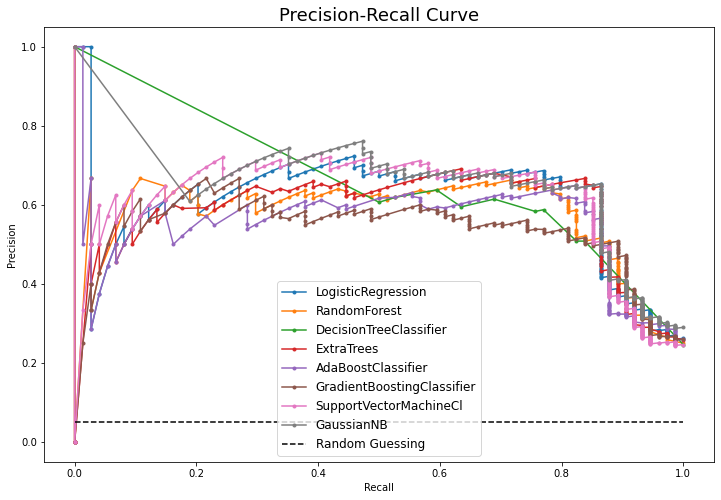

In [56]:
# Plot recall / precision curve.
plt.figure(figsize=(12,8))
plot_pr_curve(lr_gs, gs_dict)
plot_pr_curve(rf_gs, gs_dict)
plot_pr_curve(dt_gs, gs_dict)
plot_pr_curve(et_gs, gs_dict)
plot_pr_curve(ada_gs, gs_dict)
plot_pr_curve(gb_gs, gs_dict)
plot_pr_curve(svc_gs, gs_dict)
plot_pr_curve(gnb_gs, gs_dict)
plt.plot([0, 1], [0.05, 0.05], linestyle='--', color = 'black', label='Random Guessing')
plt.title('Precision-Recall Curve', fontsize=18)
plt.legend(fontsize=12);

**Observation**:
- Logistric Regression, Extra Tree and Gaussian Naive Bayes have the highest f1 score at 74%.
- Gaussian Naive Bayes has the highest precision / recall auc and highest average precision score at 66% and 63% respectively.

## Final Model

Gaussian Naive Bayes is chosen as the final model as Gaussian Naive Bayes 
- is not overfitting;
- has highest testing ROC AUC at 86%;
- has high f1 score at 74%; and
- can do better classification based on small dataset. ([source](https://www.educba.com/naive-bayes-vs-logistic-regression)). 

### Impact of Features to Gaussian Naive Bayes Modelling

SHAP (SHapley Additive exPlanations) is used to measure the contributions to the final outcome from each feature separately among the coalition, while preserving the sum of contributions being equal to the final outcome ([source](https://m.mage.ai/how-to-interpret-and-explain-your-machine-learning-models-using-shap-values-471c2635b78e)).

In [57]:
%%time
# Fits the explainer
explainer = shap.Explainer(gnb_gs.predict, X_test)
# Calculates the SHAP values
shap_values = explainer(X_test)

CPU times: total: 6.34 s
Wall time: 7.21 s


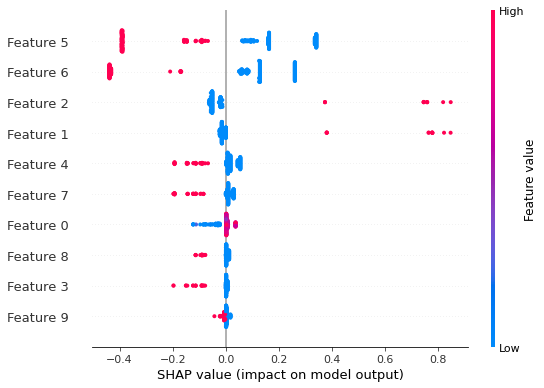

In [58]:
# Draw shap summary plot.
shap.summary_plot(shap_values)

**Mapping**:  <br>
Feature 0: `total_claim_amount`  <br>
Feature 1: `insured_hobbies_chess`  <br>
Feature 2: `insured_hobbies_cross-fit`  <br>
Feature 3: `incident_type_Parked Car` <br>
Feature 4: `incident_type_Vehicle Theft` <br>
Feature 5: `incident_severity_Minor Damage` <br>
Feature 6: `incident_severity_Total Loss` <br>
Feature 7: `incident_severity_Trivial Damage` <br>
Feature 8: `authorities_contacted_None` <br>
Feature 9: `property_damage_NO` <br>

**Observations**:
- All variables are ranked in the order of feature importance, with incident, whose severity is minor damage, being the most important and no property damage being the the least important one. X-axis, SHAP value represents the likelihood of getting positive outcome, which is prediction of fraudulent insurance claims; or negative outcome, which is prediction of non-fraudulent insurance claims. 
- Incident, whose severity type is minor damage or total damage or trivial damage, has high negative impacts, leading the model to predict non-fraudulent insurance claims. On the other hands, incident, whose severity type is minor damage or total damage or trivial damage, has low positive impact in predicting fraudulent insurance claims.
- Insureds, whose hobby is cross-fit or chess, have high positive impact, leading the model to predict fraudulent insurance claims. On the other hands, Insureds, whose hobby is cross-fit or chess, have low negative impact in predicting non-fraudulent insurance claims.
- Incident type that is vehicle theft, has high negative impact, leading the model to predict non-fraudulent insurance claims. On the other hands, incident type that is vehicle theft has low positive impact in predicting fraudulent insurance claims.
- Total claim amount has high positive impact, leading the model to predict fraudulent insurance claims. On the other hands, total claim amount has low negative impact in predicting fraudulent insurance claims.
- Authorities contact that is none has high negative impact, leading the model to predict non-fraudulent insurance claims. On the other hands, authorities contact that is none has very low positive impact, whose SHAP value is close to 0, in predicting fraudulent insurance claims.
- Incident type that is parked car, has high negative impact, leading the model to predict non-fraudulent insurance claims. On the other hands, incident type that is parked car has very low positive impact, whose SHAP value is close to 0, in predicting fraudulent insurance claims.
- No property damage has high negative impact, leading the model to predict non-fraudulent insurance claims. On the other hands, no property damage has low positive impact, leading the model to predict fraudulent insurance claims. Nonetheless, its SHAP values for both high negative impact and low positive impact are close to 0.